In [ ]:
import sys, os
from fractions import Fraction
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ms3 import transform, name2fifths, fifths2pc
sys.path.append(os.path.abspath('../python_scripts/'))
from data_types import ChordType, PitchType
from utils import get_chord_pitches
from constants import TRIAD_REDUCTION
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

def vc(S):
    """Value counts & normalized column"""
    vc = S.value_counts(dropna=False)
    return pd.concat([vc, vc / vc.sum()], axis=1, keys=['counts', 'fraction'])

In [ ]:
data = '../Data/sonatas_annotations/progressions'
csv_files = os.listdir(data)
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time  matched_duration annotation1_chord annotation2_chord dcml_label  \
01-1 0  0.00              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     1  0.25              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     2  0.50              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     3  0.75              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     4  1.00              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   

        sps  vl tbt  binary  
01-1 0  0.0   0   0   False  
     1  0.0   0   0   False  
     2  0.0   0   0   False  
     3  0.0   0   0   False  
     4  0.0   0   0   False

### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [ ]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.561696
True     0.438304
Name: binary, dtype: float64


### Data Expansion

In [ ]:
df = D[D.binary] # select only diverging
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
def is_triad(type_str):
    val = ChordType[type_str]
    return val.value < 4
df = D[D.binary]
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'triad': f"triad{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['triad'] = transform(expanded[2], is_triad)
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)

In [ ]:
def tbt_relaxed(set_a, set_b, as_distance=False):
    """Tone-by-tone but normalizing by 3 if a triad is involved.
    Returns 1 if a triad is contained in a tetrad.
    """
    n = min(len(set_a), len(set_b))
    overlap = len(set_a.intersection(set_b)) / n
    if as_distance:
        overlap = 1 - overlap
    return Fraction(overlap).limit_denominator(n)
    
def tbt_relaxed_cacheable(pc1, pc2, type1, type2, as_distance=False):
    a = set(get_chord_pitches(pc1, ChordType[type1], PitchType.MIDI) % 12)
    b = set(get_chord_pitches(pc2, ChordType[type2], PitchType.MIDI) % 12)
    return tbt_relaxed(a, b, as_distance=as_distance)

overlap = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2']).rename('overlap')
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv'),
                overlap,
               ], axis=1)
df.pc_iv = df.pc_iv.where(df.pc_iv <= 6, 12 - df.pc_iv)
df.head()

time  matched_duration  annotation1_chord annotation2_chord  \
01-1 30   5.25             0.250  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2   
     43   7.25             0.250       C_MAJOR_inv0   C_MAJ_MIN7_inv0   
     56  10.25             0.375   Db_MAJ_MAJ7_inv3  Db_MAJ_MAJ7_inv1   
     87  16.00             0.250      Ab_MAJOR_inv1     Eb_MAJOR_inv0   
     95  18.00             0.250      Ab_MAJOR_inv1     Eb_MAJOR_inv0   

        dcml_label       sps  vl  tbt  binary root1  ... pc1 root2     type2  \
01-1 30     #viio6  0.049170   2  3/8    True     E  ...   4     C  MAJ_MIN7   
     43      V(4)}  0.273761   3  1/4    True     C  ...   0     C  MAJ_MIN7   
     56   III.IVM2  0.075546  15  1/4    True    Db  ...   1    Db  MAJ_MAJ7   
     87        I6{  0.447499  12  6/7    True    Ab  ...   8    Eb     MAJOR   
     95        I6{  0.447499  12  6/7    True    Ab  ...   8    Eb     MAJOR   

         inv2  triad2 tpc2 pc2 tpc_iv  pc_iv  overlap  
01-1 30     2   False    0   0      4      4        1  
     43     0   False    0   0      0      0        1  
     56     1   False   -5   1      0      0        1  
     87     0    True   -3   3      1      5      1/3  
     95     0    True   -3   3      1      5      1/3  

[5 rows x 24 columns]

### SPS by shared tones ('relaxed tbt')
Maximum overlap is the minimum number of tones between the two chords, so if a triad's notes are all included in a tetrad, the overlap is 1.

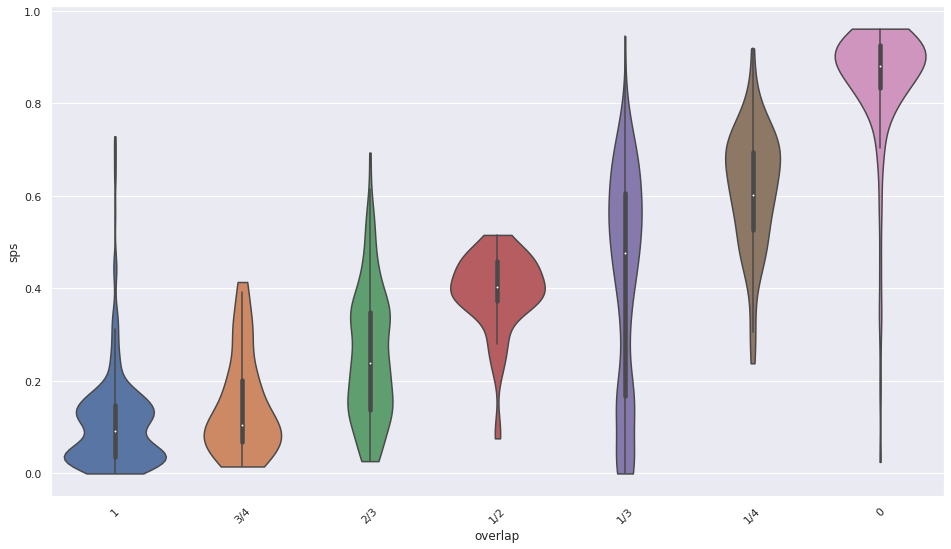

In [ ]:
sns.set(rc={"figure.figsize":(16, 9)})
sns.violinplot(data=df, x='overlap', y='sps', order=sorted(df.overlap.unique(), reverse=True), cut=0)
plt.xticks(rotation=45)
plt.show()

### Categorize divergences

**Create boolean masks**

In [ ]:
def reduce_tetrad(type_str):
    val = ChordType[type_str]
    return TRIAD_REDUCTION[val]

same_type_reduced = transform(df.type1, reduce_tetrad) == transform(df.type2, reduce_tetrad)
same_root = df.pc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2
diverging_inv = same_root & same_type
diverging_type = same_root & same_inversion

In [ ]:
ctgs = pd.Series(index=df.index, dtype='string', name='divergence')
triad_tetrad = same_root & same_type_reduced & (df.triad1 != df.triad2) # the latter part was missing in the first version of the plots. It ensures that only one is a triad
triad_tetrad_root = overlap == 1
both_triads = df.triad1 & df.triad2
selectors = (
    ('inversion', diverging_inv),
    ('triad-tetrad', triad_tetrad & same_inversion),
    ('triad-tetrad & inversion', triad_tetrad & ~same_inversion),
    ('type', diverging_type),
    ('type & inversion', same_root),
    ('triad-tetrad & root', triad_tetrad_root),
    ('no_overlap', overlap == 0),
    ('tetrads_sharing_3', overlap == 3/4),
    ('tetrads_sharing_2', overlap == 1/2),
    ('tetrads_sharing_1', overlap== 1/4),
    ('triads_sharing_2',  (overlap == Fraction(2,3)) & both_triads),
    ('triad_tetrad_sharing_2', (overlap == Fraction(2,3)) & ~both_triads),
    ('triads_sharing_1', (overlap == Fraction(1,3)) & both_triads),
    ('triad_tetrad_sharing_1', (overlap == Fraction(1,3)) & ~both_triads),
    )
for c, sel in selectors:
    ctgs = ctgs.where(ctgs.notna(), sel.map({True: c, False: pd.NA}))
## Now, fill in the uncategorized with the fraction of diverging notes
tbt_rel = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2'], as_distance=True)
ctgs = ctgs.where(ctgs.notna(), tbt_rel.astype(str))
vc(ctgs)

,counts,fraction
inversion,688,0.212608
triads_sharing_1,650,0.200865
triad-tetrad,362,0.111867
triad_tetrad_sharing_1,327,0.101051
no_overlap,294,0.090853
triad_tetrad_sharing_2,159,0.049135
triads_sharing_2,158,0.048826
triad-tetrad&root,155,0.047899
triad-tetrad&inversion,98,0.030284
type,83,0.025649


#### SPS distributions for the different categories

In [ ]:
order_by_median = df.groupby(ctgs).sps.median().sort_values().index.to_list()
labels = [f"{l} ({ctgs.value_counts(normalize=True)[l]:.1%})" for l in order_by_median]

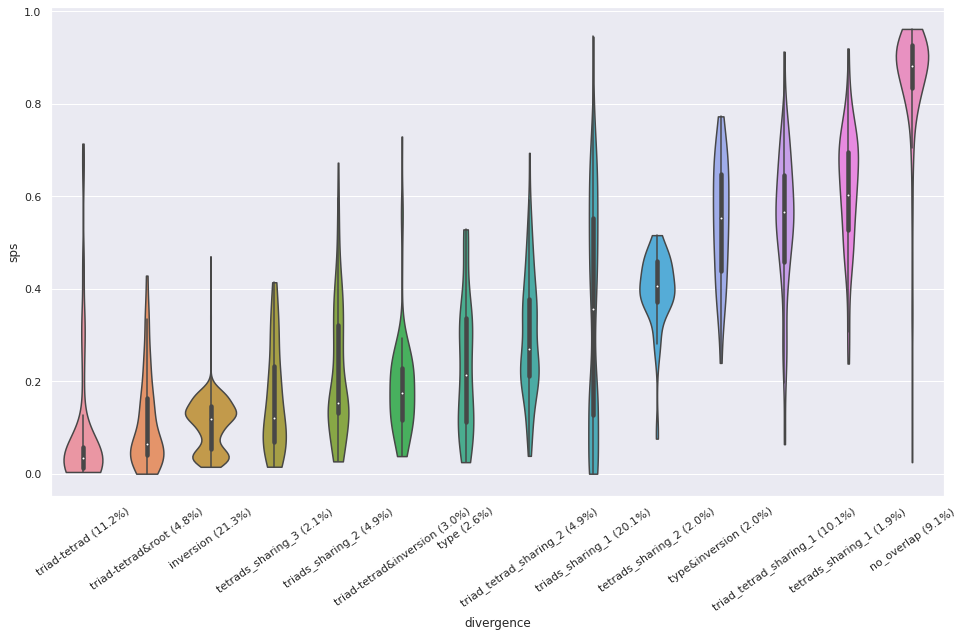

In [ ]:
sns.set(rc={"figure.figsize":(16, 9)})
ax = sns.violinplot(data=df, x=ctgs, y='sps', order=order_by_median, cut=0)
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
plt.ylabel('sps including changes')
plt.savefig('../figures/categories_sps_with_changes.png', bbox_inches='tight')
plt.show()

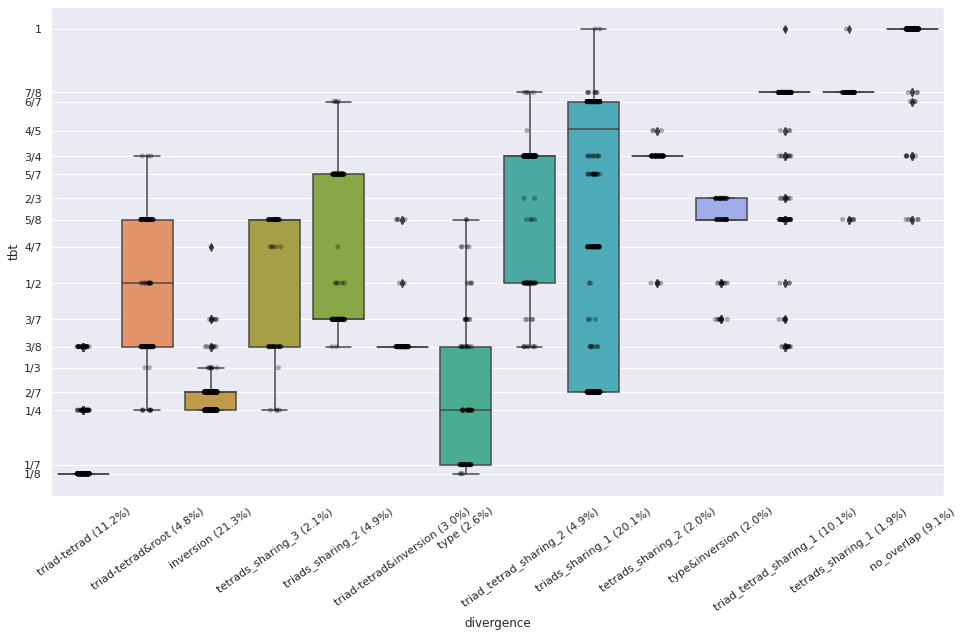

In [ ]:
ax = sns.boxplot(data=df, x=ctgs, y='tbt', order=order_by_median)
ax = sns.stripplot(data=df, x=ctgs, y='tbt', order=order_by_median, marker="o", alpha=0.3, color="black")
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
yticks = sorted(df.tbt.unique())
plt.yticks(df.tbt.astype(float).unique(), df.tbt.unique())
plt.ylabel('tbt including changes')
plt.savefig('../figures/categories_tbt_with_changes.png', bbox_inches='tight')
plt.show()

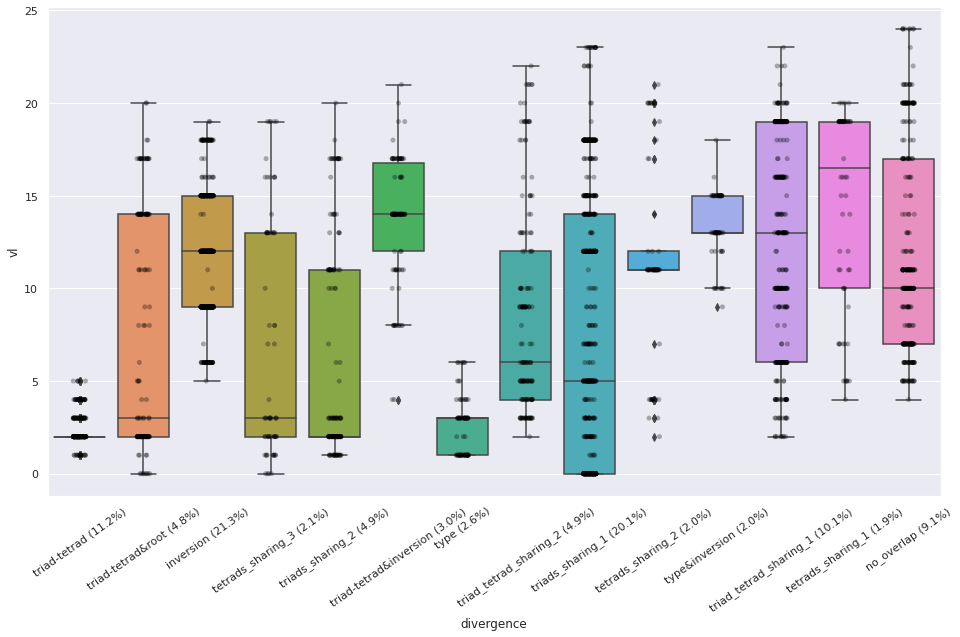

In [ ]:
ax = sns.stripplot(data=df, x=ctgs, y='vl', order=order_by_median, marker="o", alpha=0.3, color="black")
ax = sns.boxplot(data=df, x=ctgs, y='vl', order=order_by_median)
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
plt.ylabel('vl including changes')
plt.savefig('../figures/categories_vl_with_changes.png', bbox_inches='tight')
plt.show()

# Combining metrics for more fine-grained error categories
## Triad-tetrad SPS divided by VL values

In [ ]:
tri_tet = df[ctgs == 'triad-tetrad'].copy()
tri_tet.groupby('vl').sps.describe()

In [ ]:
ax = sns.boxplot(data=tri_tet, x='vl', y='sps')
ax = sns.stripplot(data=tri_tet, x='vl', y='sps', marker="o", alpha=0.3, color="black")
ax.set_xticklabels([f"{i} (n = {n})" for i, n in tri_tet.groupby('vl').size().iteritems()])
plt.show()

In [ ]:
comparisons = ('tpc', 'pc', 'type', 'inv', 'triad') 
tri_tet_groups = {compare: tri_tet[[f"{compare}1", f"{compare}2"]].apply(lambda row: tuple(sorted(row)), axis=1) for compare in comparisons}

### Chord type combinations for the different VL values
Chord combinations in this category share the same root, inversion, and reduced chord type.

In [ ]:
tri_tet.groupby([tri_tet.vl, tri_tet_groups['type']]).size()

**The three different VL values seem to be dependent on the size of the 7th**

In [ ]:
tri_tet.groupby([tri_tet.vl, tri_tet_groups['type'], tri_tet_groups['inv']]).sps.describe()

In [ ]:
tri_tet[(tri_tet.vl == 3) & (tri_tet_groups['tpc'] == (-1, -1))]

# Older code
#### Checking outliers

In [ ]:
df[ctgs == 'triads_sharing_1'].groupby('vl').sps.min()

vl
0     0.000000
1     0.023060
2     0.032372
3     0.065433
4     0.270048
5     0.283182
6     0.241781
7     0.216437
8     0.400738
9     0.130603
10    0.347198
11    0.350820
12    0.325617
13    0.272261
14    0.406678
15    0.000000
16    0.320111
17    0.403210
18    0.245541
19    0.568610
20    0.716387
22    0.396430
23    0.636311
Name: sps, dtype: float64

In [ ]:
df[(ctgs == 'triads_sharing_1') & (df.vl <= 3)]

time  matched_duration annotation1_chord annotation2_chord  \
01-1 218    34.25000          0.125000     Eb_MAJOR_inv0     Ab_MAJOR_inv2   
     250    38.25000          0.125000     Eb_MAJOR_inv0     Ab_MAJOR_inv2   
     271    41.25000          0.250000     Eb_MAJOR_inv0     Ab_MAJOR_inv2   
     281    43.25000          0.250000     Eb_MAJOR_inv0     Ab_MAJOR_inv2   
     291    45.25000          0.250000     Eb_MAJOR_inv0     Ab_MAJOR_inv2   
...              ...               ...               ...               ...   
32-1 1445  117.28125          0.270833      G_MAJOR_inv0      C_MAJOR_inv2   
     1501  123.03125          0.062500      C_MAJOR_inv0      F_MINOR_inv2   
     1709  136.53125          0.062500      G_MAJOR_inv0      C_MINOR_inv2   
     1717  137.03125          0.062500      G_MAJOR_inv0      C_MINOR_inv2   
     1765  140.03125          0.062500      G_MAJOR_inv0      C_MINOR_inv2   

          dcml_label       sps  vl  tbt  binary root1  ... pc1 root2  type2  \
01-1 218       V(64)  0.168039   0  2/7    True    Eb  ...   3    Ab  MAJOR   
     250       V(64)  0.168039   0  2/7    True    Eb  ...   3    Ab  MAJOR   
     271       V(64)  0.168039   0  2/7    True    Eb  ...   3    Ab  MAJOR   
     281       V(64)  0.168039   0  2/7    True    Eb  ...   3    Ab  MAJOR   
     291       V(64)  0.168039   0  2/7    True    Eb  ...   3    Ab  MAJOR   
...              ...       ...  ..  ...     ...   ...  ...  ..   ...    ...   
32-1 1445     V(#64)  0.069675   2  3/8    True     G  ...   7     C  MAJOR   
     1501   V(64)/iv  0.000000   0  2/7    True     C  ...   0     F  MINOR   
     1709      V(64)  0.037267   0  2/7    True     G  ...   7     C  MINOR   
     1717      V(64)  0.037267   0  2/7    True     G  ...   7     C  MINOR   
     1765      V(64)  0.037267   0  2/7    True     G  ...   7     C  MINOR   

           inv2  triad2 tpc2 pc2 tpc_iv  pc_iv  overlap  
01-1 218      2    True   -4   8      1      5      1/3  
     250      2    True   -4   8      1      5      1/3  
     271      2    True   -4   8      1      5      1/3  
     281      2    True   -4   8      1      5      1/3  
     291      2    True   -4   8      1      5      1/3  
...         ...     ...  ...  ..    ...    ...      ...  
32-1 1445     2    True    0   0      1      5      1/3  
     1501     2    True   -1   5      1      5      1/3  
     1709     2    True    0   0      1      5      1/3  
     1717     2    True    0   0      1      5      1/3  
     1765     2    True    0   0      1      5      1/3  

[286 rows x 24 columns]

In [ ]:
df[ctgs == 'triads_sharing_1'].sort_values('sps')

time  matched_duration annotation1_chord annotation2_chord  \
20-1 759    84.00000          0.083333      D_MAJOR_inv0      G_MAJOR_inv2   
21-1 2526  210.25000          0.083333      G_MAJOR_inv0      C_MAJOR_inv0   
     1328  111.25000          0.083333      G_MAJOR_inv0      C_MAJOR_inv0   
18-1 1474  153.00000          0.125000     Bb_MAJOR_inv0     Eb_MAJOR_inv0   
10-1 51      3.18750          0.062500      D_MAJOR_inv0      G_MAJOR_inv2   
...              ...               ...               ...               ...   
09-1 194    26.50000          0.250000      B_MAJOR_inv0     Gb_MAJOR_inv1   
     232    34.50000          0.125000      B_MAJOR_inv0     Gb_MAJOR_inv1   
17-1 1105  147.00000          0.250000      D_MINOR_inv1      A_MAJOR_inv1   
32-1 436    39.03125          0.062500     Bb_MAJOR_inv0      F_MINOR_inv0   
07-1 1270  210.25000          0.125000      E_MAJOR_inv0      B_MINOR_inv2   

          dcml_label       sps  vl  tbt  binary root1  ... pc1 root2  type2  \
20-1 759       V(64)  0.000000   0  2/7    True     D  ...   2     G  MAJOR   
21-1 2526      V(64)  0.000000  15  4/7    True     G  ...   7     C  MAJOR   
     1328      V(64)  0.000000  15  4/7    True     G  ...   7     C  MAJOR   
18-1 1474      V(64)  0.000000  15  4/7    True    Bb  ...  10    Eb  MAJOR   
10-1 51        V(64)  0.000000   0  2/7    True     D  ...   2     G  MAJOR   
...              ...       ...  ..  ...     ...   ...  ...  ..   ...    ...   
09-1 194           I  0.788415   5  6/7    True     B  ...  11    Gb  MAJOR   
     232           I  0.788415   5  6/7    True     B  ...  11    Gb  MAJOR   
17-1 1105         i6  0.788863  14  6/7    True     D  ...   2     A  MAJOR   
32-1 436     V(64)/V  0.852800  20    1    True    Bb  ...  10     F  MINOR   
07-1 1270    v.V(64)  0.945535  10    1    True     E  ...   4     B  MINOR   

           inv2  triad2 tpc2 pc2 tpc_iv  pc_iv  overlap  
20-1 759      2    True    1   7      1      5      1/3  
21-1 2526     0    True    0   0      1      5      1/3  
     1328     0    True    0   0      1      5      1/3  
18-1 1474     0    True   -3   3      1      5      1/3  
10-1 51       2    True    1   7      1      5      1/3  
...         ...     ...  ...  ..    ...    ...      ...  
09-1 194      1    True   -6   6     11      5      1/3  
     232      1    True   -6   6     11      5      1/3  
17-1 1105     1    True    3   9      1      5      1/3  
32-1 436      0    True   -1   5      1      5      1/3  
07-1 1270     2    True    5  11      1      5      1/3  

[650 rows x 24 columns]

In [ ]:
def get_value_pair(row, col):
    """Return value pairs such that the first one belongs to the lower of both roots."""
    col1, col2 = f"{col}1", f"{col}2"
    if (row.pc1 + row.pc_iv) % 12 != row.pc2:
        return row[col2], row[col1]
    return row[col1], row[col2]

### Inspect particular divergences
#### Two seventh chords with different roots and 3 common tones
For example, the first row, `1  (MAJ_MIN7, DIM7)  4` means: 4 instances of a dominant 7th chord and a diminished 7th chord with the root 1 semitone higher than the former.

In [ ]:
tetrads_sharing_3 = df[ctgs == 'tetrads_sharing_3']
type_groups = tetrads_sharing_3.apply(get_value_pair, col='type', axis=1).rename('types')
tetrads_sharing_3 = pd.concat([tetrads_sharing_3, type_groups], axis=1)
tetrads_sharing_3.groupby(['pc_iv', 'types']).size()

#### Two triads with different roots and 2 common tones

In [ ]:
triads_sharing_2 = df[ctgs == 'triads_sharing_2']
# here, the order of types is always (lower_root, higher_root)
type_groups = triads_sharing_2.apply(get_value_pair, col='type', axis=1).rename('types')
triads_sharing_2 = pd.concat([triads_sharing_2, type_groups], axis=1)
triads_sharing_2.groupby(['pc_iv', 'types']).size()